<a href="https://colab.research.google.com/github/UEC-MaTa/OfficeWorkManualTrial/blob/main/retry_News_Aggregator%EF%BC%88%E5%8F%82%E8%80%83%E3%80%80%E6%BC%94%E7%BF%92%EF%BC%9AStackOverflow_%E3%81%AE%E8%B3%AA%E5%95%8F%E3%81%AB%E5%AF%BE%E3%81%99%E3%82%8B%E3%83%9E%E3%83%AB%E3%83%81%E3%82%AF%E3%83%A9%E3%82%B9%E5%88%86%E9%A1%9E%E3%80%81news_category_classification_multiclass_lstm_ipyn%E3%80%81%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Aggregator
（参考）演習：StackOverflow の質問に対するマルチクラス分類
ニュースのテキスト分類を応用してみる

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
from tensorflow import keras
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical

In [2]:
print(tf.__version__)

2.12.0


In [3]:
# 下記セルを実行すると、authorization codeの入力を求められます。
# 出力されたリンク先をクリックし、Googleアカウントにログインし、
# authorization codeをコピーし、貼り付けをおこなってください。
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd

#newsCorpora.csv
newsCorpora = pd.read_csv('/content/drive/MyDrive/Tensorflow/NewsAggregator/newsCorpora.csv',sep='\t',  names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
display(newsCorpora.shape)
display(newsCorpora)

(422419, 8)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027
...,...,...,...,...,...,...,...,...
422414,422933,Surgeons to remove 4-year-old's rib to rebuild...,http://www.cbs3springfield.com/story/26378648/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1409229190251
422415,422934,Boy to have surgery on esophagus after battery...,http://www.wlwt.com/news/boy-to-have-surgery-o...,WLWT Cincinnati,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wlwt.com,1409229190508
422416,422935,Child who swallowed battery to have reconstruc...,http://www.newsnet5.com/news/local-news/child-...,NewsNet5.com,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.newsnet5.com,1409229190771
422417,422936,Phoenix boy undergoes surgery to repair throat...,http://www.wfsb.com/story/26368078/phoenix-boy...,WFSB,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wfsb.com,1409229191071


In [5]:
#2pageSessions.csv
twopageSessions = pd.read_csv('/content/drive/MyDrive/Tensorflow/NewsAggregator/2pageSessions.csv',sep='\t',  names=['STORY', 'HOSTNAME', 'CATEGORY', 'URL'])
display(twopageSessions.shape)
display(twopageSessions)

(15516, 4)

,STORY,HOSTNAME,CATEGORY,URL
0,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ http://techcrunch.com/2...
1,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ecommerce/ http://techcr...
2,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/News/2014/ http://www.bnn.ca...
3,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/news http://www.bnn.ca/News/...
4,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/News/News-Listing.aspx?Secto...
...,...,...,...,...
15511,dkPjabOt_3c58pM7cXTzwf0VDxtQM,www.upi.com,b,http://www.upi.com/ http://www.upi.com/Busines...
15512,dkPjabOt_3c58pM7cXTzwf0VDxtQM,www.webpronews.com,b,http://www.webpronews.com/ http://www.webprone...
15513,d3DTRVmvpPPpa8MG61j9MfjG4GkuM,www.smh.com.au,b,http://www.theage.com.au/travel/traveller-tips...
15514,d3DTRVmvpPPpa8MG61j9MfjG4GkuM,www.smh.com.au,b,http://www.theage.com.au/travel http://www.smh...


In [6]:
newsCorpora.dtypes

ID            int64
TITLE        object
URL          object
PUBLISHER    object
CATEGORY     object
STORY        object
HOSTNAME     object
TIMESTAMP     int64
dtype: object

In [7]:
twopageSessions.dtypes

STORY       object
HOSTNAME    object
CATEGORY    object
URL         object
dtype: object

In [8]:
#creating a new dataset with only relevant features.
ds = newsCorpora[['TITLE','CATEGORY']]
ds.head()

#shuffling rows with the help of sample, here (frac = 1) means return all rows
ds = ds.sample(frac=1).reset_index(drop=True)
ds.head()

,TITLE,CATEGORY
0,Big Bang Drama: The Cast Shuts Down Production...,e
1,'Scott was not planning company closure',e
2,Ben Affleck Is the 'Most Hated Man in America'...,e
3,Health law credits may gobble up tax refund,b
4,'Dancing With the Stars' 2014: Len Goodman Rea...,e


In [9]:
#checking for null values
ds.isnull().sum()

TITLE       0
CATEGORY    0
dtype: int64

In [10]:
#M class has way less data than the orthers, thus the classes are unbalanced.
ds.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

<Axes: xlabel='CATEGORY', ylabel='count'>

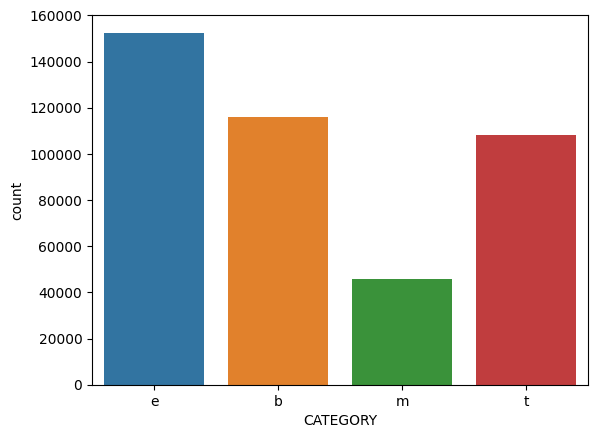

In [11]:
#plotting graph for categories
sns.countplot(x = 'CATEGORY',data = ds)

In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') #original was '<br />'
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
# Make a text-only dataset (without labels), then call adapt
train_text = ds["TITLE"]
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

上記のように、各トークンは整数に置き換えられています。レイヤーで `.get_vocabulary()` を呼び出すことにより、各整数が対応するトークン（文字列）を検索できます。

In [16]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  girlfriend
 313 --->  search
Vocabulary size: 10000


In [17]:
# ★
for i in range(20):
  print(i, " ---> ",vectorize_layer.get_vocabulary()[i])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

0  --->  
1  --->  [UNK]
2  --->  to
3  --->  the
4  --->  in
5  --->  of
6  --->  for
7  --->  on
8  --->  and
9  --->  a
10  --->  with
11  --->  new
12  --->  at
13  --->  is
14  --->  us
15  --->  as
16  --->  from
17  --->  after
18  --->  google
19  --->  by
Vocabulary size: 10000


In [18]:
#splitting the Dataset into Train and Test set
x_train,x_test,y_train,y_test=train_test_split(ds['TITLE'],ds['CATEGORY'],test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(337935,) (337935,)
(84484,) (84484,)


モデルをトレーニングする準備がほぼ整いました。最後の前処理ステップとして、トレーニング、検証、およびデータセットのテストのために前に作成した TextVectorization レイヤーを適用します。

In [19]:
train_ds = vectorize_text(x_train,y_train)
val_ds = vectorize_text(x_test,y_test)
#test_ds = raw_test_ds.map(vectorize_text)

In [31]:
print(train_ds)

(<tf.Tensor: shape=(337935, 250), dtype=int64, numpy=
array([[1507,  275,   37, ...,    0,    0,    0],
       [2400,  509, 5133, ...,    0,    0,    0],
       [  77, 3970,    2, ...,    0,    0,    0],
       ...,
       [   1, 3941, 1021, ...,    0,    0,    0],
       [ 153,  288,   33, ...,    0,    0,    0],
       [1671,  114, 1221, ...,    0,    0,    0]])>, 401829    t
346394    e
211407    t
276617    e
7486      b
         ..
259178    b
365838    b
131932    b
146867    b
121958    e
Name: CATEGORY, Length: 337935, dtype: object)


In [48]:
print(train_ds[0])

tf.Tensor(
[[1507  275   37 ...    0    0    0]
 [2400  509 5133 ...    0    0    0]
 [  77 3970    2 ...    0    0    0]
 ...
 [   1 3941 1021 ...    0    0    0]
 [ 153  288   33 ...    0    0    0]
 [1671  114 1221 ...    0    0    0]], shape=(337935, 250), dtype=int64)


In [98]:
print(train_ds[1])

401829    t
346394    e
211407    t
276617    e
7486      b
         ..
259178    b
365838    b
131932    b
146867    b
121958    e
Name: CATEGORY, Length: 337935, dtype: object


In [32]:
print(val_ds)
#print(test_ds)

(<tf.Tensor: shape=(84484, 250), dtype=int64, numpy=
array([[ 385,   80,  889, ...,    0,    0,    0],
       [2919, 2830,   13, ...,    0,    0,    0],
       [4186,    1, 2216, ...,    0,    0,    0],
       ...,
       [ 557,    8,    1, ...,    0,    0,    0],
       [ 713,  107,  619, ...,    0,    0,    0],
       [ 155, 1400, 2997, ...,    0,    0,    0]])>, 280241    m
96315     b
280410    b
284975    b
379072    b
         ..
285679    b
75946     t
341119    e
322763    b
259267    e
Name: CATEGORY, Length: 84484, dtype: object)


In [ ]:
"""
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
"""

In [ ]:
"""
print(train_ds)
print(val_ds)
#print(test_ds)
"""

In [39]:
print(train_ds[0][0])

tf.Tensor(
[1507  275   37  641    1 3145 2562 3265   42    3  147 1611    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [93]:
print("Lavel", train_ds[1][2])

KeyError: ignored

In [100]:
# ★
for i in range(20): #20個目の文章までとってみた
  print(i)
  print("Review", train_ds[0][i].numpy()[:10]) #10個目の単語までとってみた
  print("Lavel", train_ds[1][i])

0
Review [1507  275   37  641    1 3145 2562 3265   42    3]
Lavel e
1
Review [2400  509 5133 5337    8 4709    7    3  492   67]
Lavel e
2
Review [  77 3970    2   21  488    7  426 1349    0    0]


KeyError: ignored

### モデルを作成する

ニューラルネットワークを作成します。

In [23]:
embedding_dim = 16

In [105]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)]) #4 つの出力クラスがあるため、モデルの最後のレイヤーを Dense(4) に変更します。

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_6 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

### 損失関数とオプティマイザ

モデルをトレーニングするには、損失関数とオプティマイザが必要です。これは二項分類問題であり、モデルは確率（シグモイドアクティベーションを持つ単一ユニットレイヤー）を出力するため、`losses.BinaryCrossentropy` 損失関数を使用します。

損失関数の候補はこれだけではありません。例えば、`mean_squared_error`（平均二乗誤差）を使うこともできます。しかし、一般的には、確率を扱うには`binary_crossentropy`の方が適しています。`binary_crossentropy`は、確率分布の間の「距離」を測定する尺度です。今回の場合には、真の分布と予測値の分布の間の距離ということになります。

★
モデルをコンパイルするときは、損失を tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) に変更します。これは、各クラスのラベルが整数である場合に、マルチクラス分類問題に使用する正しい損失関数です。(この場合、 0、1、2、または 3 のいずれかになります)。さらに、これはマルチクラス分類の問題であるため、メトリックを metrics=['accuracy'] に変更します (tf.metrics.BinaryAccuracy はバイナリ分類器にのみ使用されます)。

In [102]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True), #original was BinaryCrossentropy(from_logits=True)
              optimizer='adam',
              metrics='accuracy')  #original was tf.metrics.BinaryAccuracy(threshold=0.0))

### モデルをトレーニングする

`dataset` オブジェクトを fit メソッドに渡すことにより、モデルをトレーニングします。

In [103]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50


ValueError: ignored

### モデルを評価する

モデルがどのように実行するか見てみましょう。2 つの値が返されます。損失（誤差、値が低いほど良）と正確度です。

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

NameError: ignored

### 経時的な正解度と損失のグラフを作成する

`model.fit()` は、トレーニング中に発生したすべての情報を詰まったディクショナリを含む `History` オブジェクトを返します。

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

トレーニングと検証中に監視されている各メトリックに対して 1 つずつ、計 4 つのエントリがあります。このエントリを使用して、トレーニングと検証の損失とトレーニングと検証の正解度を比較したグラフを作成することができます。

経時的な精度をプロットする場合は、binary_accuracy および val_binary_accuracyをそれぞれ accuracy および val_accuracy に変更します。

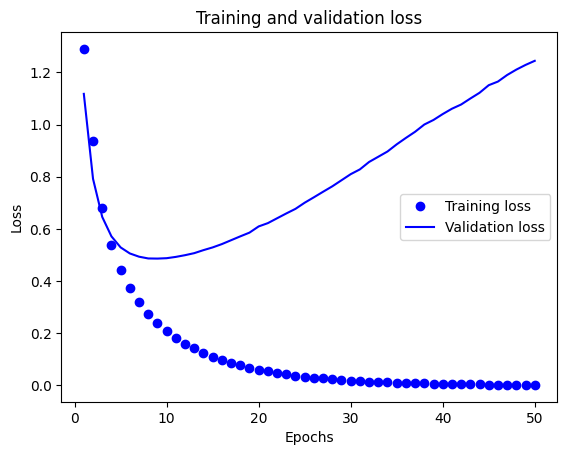

In [ ]:
acc = history_dict['accuracy'] #original was 'binary_accuracy'
val_acc = history_dict['val_accuracy'] #original was 'val_binary_accuracy'
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

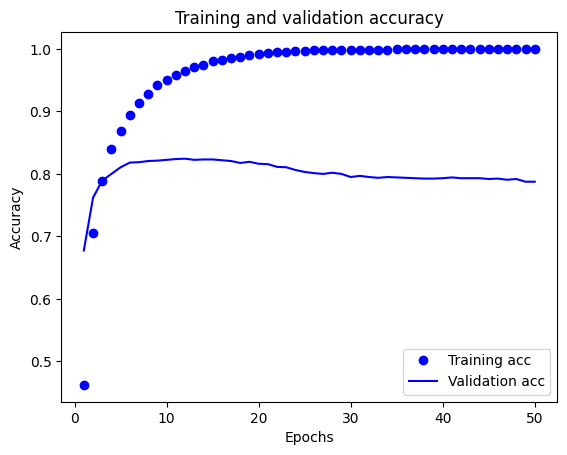

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

このグラフでは、点はトレーニングの損失と正解度を表し、実線は検証の損失と正解度を表します。

トレーニングの損失がエポックごとに*下降*し、トレーニングの正解度がエポックごとに*上昇*していることに注目してください。これは、勾配下降最適化を使用しているときに見られる現象で、イテレーションごとに希望する量を最小化します。

これは検証の損失と精度には当てはまりません。これらはトレーニング精度の前にピークに達しているようです。これが過適合の例で、モデルが、遭遇したことのないデータよりもトレーニングデータで優れたパフォーマンスを発揮する現象です。この後、モデルは過度に最適化し、テストデータに*一般化*しないトレーニングデータ*特有*の表現を学習します。

この特定のケースでは、検証の正解度が向上しなくなったときにトレーニングを停止することにより、過適合を防ぐことができます。これを行うには、`tf.keras.callbacks.EarlyStopping` コールバックを使用することができます。

★https://qiita.com/yukiB/items/f45f0f71bc9739830002
**EarlyStopping**
学習ループに収束判定を付与することができます．監視する値を設定し，それが収束したら自動的にループを抜ける処理になります．

keras.callbacks**.EarlyStopping**(monitor='val_loss', patience=0, verbose=0, mode='auto')

**arguments**	description
**monitor**	監視値指定．例えば，monitor='val_loss'
**patience**	ループの最低数
**verbose**	保存時に標準出力にコメントを出すか指定．{0, 1}
**mode**	上限，下限どちらの側に収束した場合に収束判定を出すかの規定．{auto, min, max}
上記の設定で，以下のように学習ループ途中であっても収束判定がかかり，ループから抜けることができます(下記の表示はverbose=1に設定していた場合)．

## モデルをエクスポートする

上記のコードでは、モデルにテキストをフィードする前に、`TextVectorization` レイヤーをデータセットに適用しました。モデルで生の文字列を処理できるようにする場合 (たとえば、展開を簡素化するため)、モデル内に `TextVectorization` レイヤーを含めることができます。これを行うには、トレーニングしたばかりの重みを使用して新しいモデルを作成します。

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 5s 19ms/step - loss: 1.4630 - accuracy: 0.7653
0.765250027179718


### 新しいデータの推論

新しい例の予測を取得するには、`model.predict()`を呼び出します。

★
Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python

In [ ]:
#Overstockflowから実例をコピペしてみた
examples = [
  #C##事例
  "I am developing a survivor game using the Qt framework with C++ language. Currently, I am implementing in-game saving functionality. My game consists of three main windows: MainWindow, ChooseScene, and Game. The gameplay interface is displayed in the Game window. However, since my windows are implemented as pointers, they contain multiple pointers internally. After saving a game, I clear the memory of the relevant pointers and set them to nullptr. When starting a new game, I allocate memory for them again. The problem I'm facing is that whenever I attempt to start a second round of a new game, the program crashes. I have a MainWindow window, and within its class, there is a pointer object called ChooseScene. Inside this pointer object, there is another pointer object called Game. When I click on Save and Exit, both the Game and ChooseScene windows are closed. At the same time, I use QSettings to save the data and delete these two pointers, which triggers the destructor of each object, deleting other pointer members within them. Finally, the MainWindow window appears. During the debugging process, I added numerous output statements to identify where the program crashes. Eventually, I discovered that the crash occurs right after executing the destructor of the Game object. However, I'm unsure how to resolve this issue. I'm seeking assistance to help identify and resolve this bug. Since I am a beginner, my code is quite lengthy, spanning over 1000 lines. If possible, it would be great to receive suggestions on how to fully implement the in-game saving functionality. Here is my code link:",
  #Java事例
  "I'm writing a ray tracer for which I need to cast rays from the screen into the world. I'm using the inverse of the view-projection-viewport matrix to get back from screen pixel coordinates to world space coordinates. I noticed by accident that two elements of the inverse matrix are always 0, no matter how or where I move, zoom, orbit, or spin the camera. I don't understand the projection matrix deeply enough to know why. This is a hopefully-relevant portion of my Matrix class:",
  #JavaScript事例
  "I was trying to update and delete data using forms with laravel but I cannot send the id using javascript. These are the scripts <script type=text/javascript> $(document).on(click, .edit_modal, function () {var data_id = $(this).data('id'); var data_name = $(this).data(name); $(.form-group #edit_name).val(data_name);});</script><script type=text/javascript>$(document).on(click, .delete_modal, function () {var data_id = $(this).data(id);});</script>And these are the for",
  #Python事例
  "I'm trying to make a small asynchronous application, based on a well-working code from GitHub here. I tried to alter it a little to fit my needs in this way main.py import asyncio from kernel.init import Init async def main(): init = Init() await init.loadSymbols() if __name__ == '__main__': loop = asyncio.new_event_loop() asyncio.run(main()) init.py"
]

export_model.predict(examples)

1/1 [==============================] - 0s 163ms/step


array([[1.0000000e+00, 5.6247762e-03, 1.4214570e-08, 2.3937970e-01],
       [7.2040498e-01, 6.2187579e-02, 1.4914745e-01, 9.7825456e-01],
       [9.9805123e-01, 5.9182366e-06, 9.9972266e-01, 7.6908812e-02],
       [6.0464587e-02, 1.5834800e-04, 3.6910981e-01, 9.9999946e-01]],
      dtype=float32)

In [ ]:
#Overstockflowから実例をコピペしてみた
examples = [
    "python",
    "java",
    "java script",
    "c"
]

export_model.predict(examples)

1/1 [==============================] - 0s 72ms/step


array([[0.5770613 , 0.6207191 , 0.48232028, 0.2525707 ],
       [0.5731874 , 0.36856958, 0.7113974 , 0.3645449 ],
       [0.46860415, 0.2534624 , 0.8119693 , 0.5873387 ],
       [0.5874888 , 0.54013544, 0.4845986 , 0.33849216]], dtype=float32)

モデル内にテキスト前処理ロジックを含めると、モデルを本番環境にエクスポートして展開を簡素化し、[トレーニング/テストスキュー](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)の可能性を減らすことができます。

TextVectorization レイヤーを適用する場所を選択する際に性能の違いに留意する必要があります。モデルの外部で使用すると、GPU でトレーニングするときに非同期 CPU 処理とデータのバッファリングを行うことができます。したがって、GPU でモデルをトレーニングしている場合は、モデルの開発中に最高のパフォーマンスを得るためにこのオプションを使用し、デプロイの準備ができたらモデル内に TextVectorization レイヤーを含めるように切り替えることをお勧めします。

モデルの保存の詳細については、この[チュートリアル](https://www.tensorflow.org/tutorials/keras/save_and_load)にアクセスしてください。

## 詳細

このチュートリアルでは、最初からテキスト分類を実行する方法を紹介しました。一般的なテキスト分類ワークフローの詳細については、Google Developers の[テキスト分類ガイド](https://developers.google.com/machine-learning/guides/text-classification/)をご覧ください。
